<a href="https://colab.research.google.com/github/Eric-Oliveira-ds/computer-vision/blob/main/Train_a_Custom_Keypoint_Detection_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train a Custom Keypoint Detection Model

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports and Utils

In [2]:
# imports
import cv2
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import os
import glob

from sklearn.model_selection import train_test_split

In [3]:
# Utils

def draw_points_and_lines(image_path:str, annotation_path:str):

    # Carregar a imagem original
    imagem = cv2.imread(image_path)

    # Ler o arquivo CSV com as coordenadas dos pontos-chave
    dados = pd.read_csv(annotation_path, header=None, nrows=7)

    # Extrair as coordenadas do DataFrame
    coordenadas_pontos = [(x, y) for x, y in zip(dados[0], dados[1])]

    # Definir a cor dos pontos (B, G, R) e das linhas
    cor_ponto = (0, 255, 0)  # Verde (em ordem BGR)
    #cor_linha = (0, 0, 255)  # Vermelho (em ordem BGR)

    # Desenhar os pontos na imagem
    for (x, y) in coordenadas_pontos:
        cv2.circle(imagem, (x, y), 5, cor_ponto, -1)  # Desenha um círculo de raio 5

    # Desenhar as linhas entre os pontos
    # for i in range(len(coordenadas_pontos) - 1):
    #     ponto_atual = coordenadas_pontos[i]
    #     proximo_ponto = coordenadas_pontos[i + 1]
    #     cv2.line(imagem, ponto_atual, proximo_ponto, cor_linha, 2)  # Desenha uma linha de espessura 2

    # Mostrar a imagem com os pontos e linhas desenhados
    cv2_imshow(imagem)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return True

In [4]:
# Função para redimensionar os pontos-chave de acordo com o redimensionamento da imagem
def resize_keypoints(keypoints, orig_size, new_size):

    """
    resized_keypoints :

    Essa função resize_keypoints recebe três argumentos: keypoints, orig_size e new_size.
    A função é responsável por redimensionar os pontos-chave de acordo com o redimensionamento da imagem.

    Ela calcula as razões de escala para os eixos x e y, dividindo o novo tamanho (new_size) pelo tamanho original (orig_size).
    Em seguida, itera sobre os pontos-chave e multiplica suas coordenadas originais pelas razões de escala, convertendo-as em inteiros.
    Isso redimensiona os pontos-chave para corresponderem ao novo tamanho da imagem.

    A função retorna a lista de pontos-chave redimensionados (resized_keypoints).

    Portanto, essa função é útil para garantir que os pontos-chave estejam corretamente redimensionados juntamente com as imagens quando ocorrer o redimensionamento.
    """

    ratio_x = new_size[0] / orig_size[0]
    ratio_y = new_size[1] / orig_size[1]
    resized_keypoints = [[int(keypoint[0] * ratio_x), int(keypoint[1] * ratio_y)] for keypoint in keypoints]

    return resized_keypoints

In [5]:
# Função para redimensionar as imagens e os pontos-chave
def resize_images_and_keypoints(image_paths, annotation_paths, new_size):

    """
    A função resize_images_and_keypoints recebe três argumentos: image_paths, annotation_paths e new_size.
    Essa função é responsável por redimensionar as imagens e os pontos-chave de acordo com o tamanho especificado por new_size.

    A função itera sobre os caminhos das imagens e os caminhos das anotações correspondentes, carrega cada imagem, redimensiona-a para o novo tamanho especificado e adiciona a imagem redimensionada à lista resized_images.
    Em seguida, carrega os pontos-chave do arquivo CSV associado à imagem, redimensiona esses pontos-chave usando a função resize_keypoints, e adiciona os pontos-chave redimensionados à lista resized_keypoints.

    Ao final do loop, a função retorna as listas de imagens redimensionadas (resized_images) e os pontos-chave redimensionados (resized_keypoints).

    Essa função permite redimensionar tanto as imagens quanto os pontos-chave de forma conveniente, garantindo que estejam alinhados corretamente após o redimensionamento.
    """
    resized_images = []
    resized_keypoints = []

    for image_path, annotation_path in zip(image_paths, annotation_paths):
        # Carregar imagem
        image = cv2.imread(image_path)
        # Redimensionar imagem
        resized_image = cv2.resize(image, new_size)
        # Adicionar imagem redimensionada à lista
        resized_images.append(resized_image)
        # Carregar pontos-chave do arquivo CSV
        with open(annotation_path, 'r') as file:
            annotation_data = csv.reader(file)
            keypoints = [[int(coord) for coord in row] for row in annotation_data]
        # Redimensionar pontos-chave
        resized_keypoints = resize_keypoints(keypoints, image.shape[:2], new_size)
        # Adicionar pontos-chave redimensionados à lista
        resized_keypoints.append(resized_keypoints)

    return resized_images, resized_keypoints

## Data Extration

-  100 imagens do video (braço flexível e mão do soft robot)

In [6]:
# Diretório das imagens e anotações
image_directory = '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation'

# Padrão para as extensões das imagens e anotações
image_pattern = "*.jpg"
annotation_pattern = "*.csv"

# Lista de caminhos das imagens
image_paths = glob.glob(f"{image_directory}/{image_pattern}")
annotation_path = glob.glob(f"{image_directory}/{annotation_pattern}")

# Obter nomes base das imagens (sem extensão)
image_names = [os.path.splitext(os.path.basename(path))[0] for path in image_paths]

In [7]:
image_names[:10]

['frame_0',
 'frame_2',
 'frame_1',
 'frame_3',
 'frame_5',
 'frame_4',
 'frame_6',
 'frame_7',
 'frame_9',
 'frame_8']

In [8]:
image_paths[:5]

['/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_0.jpg',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_2.jpg',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_1.jpg',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_3.jpg',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_5.jpg']

In [9]:
annotation_path[:5]

['/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_27.jpg.csv',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_5.jpg.csv',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_31.jpg.csv',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_40.jpg.csv',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_44.jpg.csv']

## Split - Train, Validation and Test

In [10]:
# Dividir os dados em treino, validação e teste
train_ratio = 0.7  # proporção para treino
val_ratio = 0.15  # proporção para validação
test_ratio = 0.15  # proporção para teste

In [11]:
# Dividir os nomes das imagens
train_names, val_test_names = train_test_split(image_names, test_size=(1 - train_ratio), random_state=1)
val_names, test_names = train_test_split(val_test_names, test_size=test_ratio/(val_ratio + test_ratio), random_state=1)

In [12]:
# Obter os caminhos completos das imagens e anotações para cada conjunto
train_paths = [os.path.join(image_directory, f"{name}.jpg") for name in train_names]
val_paths = [os.path.join(image_directory, f"{name}.jpg") for name in val_names]
test_paths = [os.path.join(image_directory, f"{name}.jpg") for name in test_names]

In [13]:
# Obter os caminhos dos arquivos de anotação correspondentes
train_annotation_paths = [os.path.join(image_directory, f"{name}.jpg.csv") for name in train_names]
val_annotation_paths = [os.path.join(image_directory, f"{name}.jpg.csv") for name in val_names]
test_annotation_paths = [os.path.join(image_directory, f"{name}.jpg.csv") for name in test_names]

### Train

In [14]:
len(train_annotation_paths)

69

In [15]:
len(train_paths)

69

In [16]:
train_annotation_paths[:5]

['/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_99.jpg.csv',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_54.jpg.csv',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_95.jpg.csv',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_87.jpg.csv',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_39.jpg.csv']

In [17]:
train_paths[:5]

['/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_99.jpg',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_54.jpg',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_95.jpg',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_87.jpg',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_39.jpg']

In [18]:
frame_99 = cv2.imread('/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_99.jpg')

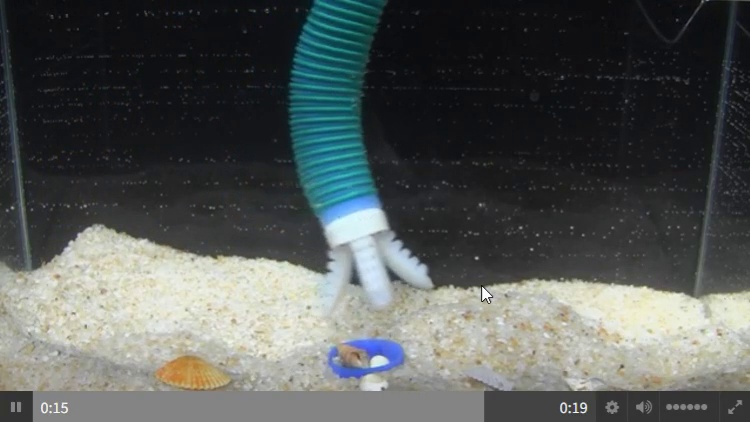

In [19]:
cv2_imshow(frame_99)

- Desenhar pontos usando a coordenada x, y do csv anotado

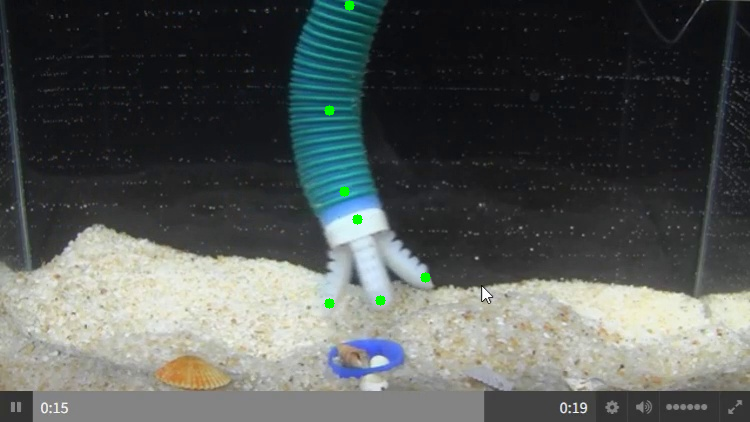

True

In [20]:
draw_points_and_lines('/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_99.jpg',
                     '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_99.jpg.csv')

### Validation

In [21]:
len(val_annotation_paths)

15

In [22]:
val_annotation_paths

['/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_36.jpg.csv',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_53.jpg.csv',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_83.jpg.csv',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_45.jpg.csv',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_84.jpg.csv',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_31.jpg.csv',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_80.jpg.csv',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_32.jpg.csv',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_66.jpg.csv',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_37.jpg.csv',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_65.jpg.csv',

In [23]:
len(val_paths)

15

In [24]:
val_paths

['/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_36.jpg',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_53.jpg',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_83.jpg',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_45.jpg',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_84.jpg',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_31.jpg',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_80.jpg',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_32.jpg',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_66.jpg',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_37.jpg',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_65.jpg',
 '/content/drive/MyDrive/SENAI CIMATEC - Co

### Test

In [25]:
len(test_annotation_paths)

16

In [26]:
test_annotation_paths

['/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_27.jpg.csv',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_81.jpg.csv',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_10.jpg.csv',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_61.jpg.csv',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_96.jpg.csv',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_74.jpg.csv',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_1.jpg.csv',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_78.jpg.csv',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_92.jpg.csv',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_35.jpg.csv',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_44.jpg.csv',


In [27]:
len(test_paths)

16

In [28]:
test_paths

['/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_27.jpg',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_81.jpg',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_10.jpg',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_61.jpg',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_96.jpg',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_74.jpg',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_1.jpg',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_78.jpg',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_92.jpg',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_35.jpg',
 '/content/drive/MyDrive/SENAI CIMATEC - Colab/Files/imagens_annotation/frame_44.jpg',
 '/content/drive/MyDrive/SENAI CIMATEC - Col

## Pré-processing

    - Resize image
    - Normalize image

In [29]:
# Redimensionar imagens de treino, validação e teste
new_size_img = (128, 128)

resized_images_train, resized_keypoints_train =  resize_images_and_keypoints(train_paths, train_annotation_paths, new_size_img)
resized_images_val, resized_keypoints_val =  resize_images_and_keypoints(val_paths, val_annotation_paths, new_size_img)

In [30]:
len(resized_images_train[0]), len(resized_keypoints_train[0])

(128, 2)

In [31]:
len(resized_images_val[0]), len(resized_keypoints_val[0])

(128, 2)

## Training

## Test

# Evaluate

# Results